# Data Downloading and Processing

## Mount Google Drive (Google Colab)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

**First visit the NCBI-PubChem and search for Lung Cancer and go to BioAssay and download the CSV files which contains Assay ID with ChEMBL IDs (i.e. CHEMBL695700) and copy the whole column to a new CSV file and add header (chembl_id).**

## SDF Downlading from ChEMBL (Colab)

In [ ]:
import os
import requests
import pandas as pd
from google.colab import files
import shutil

# Upload the CSV file
uploaded = files.upload()

# Load the CSV file with ChEMBL IDs
uploaded_file = next(iter(uploaded))
df = pd.read_csv(uploaded_file)

# Extract ChEMBL IDs from the CSV file
chembl_ids = df['chembl_id'].tolist()

# Define the output directory
output_dir = 'ChEMBL_data'
os.makedirs(output_dir, exist_ok=True)

# Define activity thresholds (you can adjust these as needed)
active_threshold = 5.0  # Example threshold for considering compounds as active

# Create a single directory for all data
all_data_dir = 'All_ChEMBL_data'
os.makedirs(all_data_dir, exist_ok=True)

# Function to download and save SDF file
def download_sdf(compound_id, directory):
    sdf_url = f'https://www.ebi.ac.uk/chembl/api/data/molecule/{compound_id}.sdf'
    response = requests.get(sdf_url)

    if response.status_code == 200:
        with open(os.path.join(directory, f'{compound_id}.sdf'), 'wb') as sdf_file:
            sdf_file.write(response.content)
        return True
    else:
        print(f"Failed to download SDF for compound {compound_id}")
        return False

for i, chembl_id in enumerate(chembl_ids):
    print(f"Processing compound {i+1}/{len(chembl_ids)}")

    # Retrieve compounds for the assay with activity data
    response = requests.get(f'https://www.ebi.ac.uk/chembl/api/data/activity.json?assay_chembl_id={chembl_id}')

    if response.status_code == 200:
        activity_data = response.json()

        for compound in activity_data['activities']:
            # Check if the compound is active based on your threshold
            if compound['standard_value'] is not None and float(compound['standard_value']) <= active_threshold:
                activity = 'Active'
            else:
                activity = 'Inactive'

            compound_id = compound['molecule_chembl_id']

            # Download SDF file
            download_sdf(compound_id, all_data_dir)
            original_file = os.path.join(all_data_dir, f'{compound_id}.sdf')
            new_file_name = f'{activity}_{chembl_id}_{compound_id}.sdf'
            try:
              os.rename(original_file, os.path.join(all_data_dir, new_file_name))
              print(f"Downloaded SDF for {activity} compound {compound_id} in assay {chembl_id}")
            except FileNotFoundError:
              print(f"Failed to rename SDF for {activity} compound {compound_id} in assay {chembl_id}")

print("Download complete, Now saving to your Device")

# Compress the All_ChEMBL_data directory into a ZIP file
shutil.make_archive("/content/All_ChEMBL_data", 'zip', ".", "All_ChEMBL_data")

# Download the ZIP file
files.download("/content/All_ChEMBL_data.zip")

## Printing list of 3D and 2D Structures separately to verify them

In [ ]:
#Printing list of 3D and 2D Structures separately.
import os
from rdkit import Chem

# Directory containing SDF files
directory_path = 'C:/Users/Shaba/Desktop/1/All_ChEMBL_data/'

# Lists to store 2D and 3D structure files
sdf_2d_files = []
sdf_3d_files = []

# List all SDF files in the directory
sdf_files = [f for f in os.listdir(directory_path) if f.endswith('.sdf')]

for sdf_file in sdf_files:
    sdf_file_path = os.path.join(directory_path, sdf_file)

    # Load the SDF file
    suppl = Chem.SDMolSupplier(sdf_file_path)

    # Check if the first molecule is 2D or 3D
    molecule = next(suppl, None)  # Use next() to avoid a StopIteration error
    if molecule is not None and molecule.GetNumConformers() > 0:
        sdf_3d_files.append(sdf_file)
        #print("This is the 3D Files", sdf_file)
    else:
        sdf_2d_files.append(sdf_file)
        #print("This is the 2D Files", sdf_file)

#print("Files with 3D structures:")
#for file in sdf_3d_files:
   # print(file)

print("\nFiles with 2D structures:")
for file in sdf_2d_files:
    print(file)

## Removing Unnecessary Content in SDF File to import it in any software

In [ ]:
import os
from rdkit import Chem
from rdkit.Chem import AllChem

# Define the directory where your SDF files are located
input_directory = 'C:/Users/Shaba/Desktop/1/All_ChEMBL_data/'
output_directory = 'C:/Users/Shaba/Desktop/1/Updated Data/'

# Iterate over SDF files in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith('.sdf'):
        input_sdf = os.path.join(input_directory, filename)
        output_sdf = os.path.join(output_directory, filename)

        # Create a writer for the output SDF file
        writer = Chem.SDWriter(output_sdf)

        # Iterate over compounds in the input SDF file
        suppl = Chem.SDMolSupplier(input_sdf)
        for mol in suppl:
            if mol is not None:
                # Remove the <chembl_pref_name> tag
                if '<chembl_pref_name>' in mol.GetPropsAsDict():
                    mol.ClearProp('<chembl_pref_name>')

                # Update the molecule's properties and write it to the output SDF file
                writer.write(mol)

        # Close the output SDF file
        writer.close()

print("Processing complete. Modified SDF files are saved in the output directory.")

## Merge Active and Inactive Compounds to make Library
Keep all the Downloaded data in single directory and merge them to make a one file for active and one file for inactive

In [ ]:
#Merging the ACTIVE Compounds
#Note IT WILL SAVE THE FILE WHERE PYTHON FILE IS SAVED

import os
from rdkit import Chem
from rdkit.Chem import SDWriter

# Directory where your SDF files are located
input_directory = 'C:/Users/Shaba/Desktop/11/'
output_file = 'Active_ChEMBL_Lung_Cancer_1.sdf'
active_compounds = 0

# Initialize an SDWriter for the output file
output_writer = SDWriter(output_file)

# Iterate through the files in the directory
for filename in os.listdir(input_directory):
    if filename.startswith('Active_'):
        # Open the SDF file
        suppl = Chem.SDMolSupplier(os.path.join(input_directory, filename))
        for mol in suppl:
            if mol is not None:
                output_writer.write(mol)
                active_compounds += 1

# Close the output writer
output_writer.close()

# Rename the output file to include the count of active compounds
output_file_with_count = f'Active_ChEMBL_Lung_Cancer_{active_compounds}.sdf'

# Check if the file with the new name already exists and delete it if it does
if os.path.exists(output_file_with_count):
    os.remove(output_file_with_count)

os.rename(output_file, output_file_with_count)

print(f'{active_compounds} active compounds have been merged into {output_file_with_count}')
print("DONE")


## Remove Duplicates in SDF

In [ ]:
pip install rdkit-pypi

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import SDMolSupplier, SDWriter

def remove_duplicates(input_sdf, output_sdf):
    # Load the SDF file
    suppl = SDMolSupplier(input_sdf)

    # Initialize a set to store unique structures
    unique_structures = set()

    # Create a new SDF file for writing unique structures
    writer = SDWriter(output_sdf)

    # Define a salt remover to remove salts if needed
    remover = SaltRemover()

    # Iterate through each molecule in the SDF file
    for mol in suppl:
        if mol is not None:
            # Remove salts if necessary
            mol = remover.StripMol(mol)

            # Generate a canonical SMILES representation
            canonical_smiles = Chem.MolToSmiles(mol, canonical=True)

            # Check if the structure is unique
            if canonical_smiles not in unique_structures:
                unique_structures.add(canonical_smiles)

                # Write the unique structure to the output SDF file
                writer.write(mol)

    # Close the output SDF file
    writer.close()

# Example usage
input_sdf_file = "C:Active_ChEMBL_18349_3D_ligprep_Activity.sdf"
output_sdf_file = "C:Active_ChEMBL_18349_3D_ligprep_Activity_output_unique.sdf"
remove_duplicates(input_sdf_file, output_sdf_file)
print("Saved")

## Add Activity in the compound, Active =1

In [ ]:
#ACTIVE
#input file
fin = open("C:/Users/Shaba/Desktop/Active_ChEMBL_18349_3D_ligprep.sdf", "rt")
#output file to write the result to
fout = open("C:/Users/Shaba/Desktop/Active_ChEMBL_18349_3D_ligprep_Activity.sdf", "wt")
#for each line in the input file
for line in fin:
	#read replace the string and write to output file
	fout.write(line.replace('$$$$', '> <Activity>\n1\n\n$$$$'))
#close input and output files
fin.close()
fout.close()

print("Done")

# Molecular Dynamics Simulation Plots

## RMSD Plot

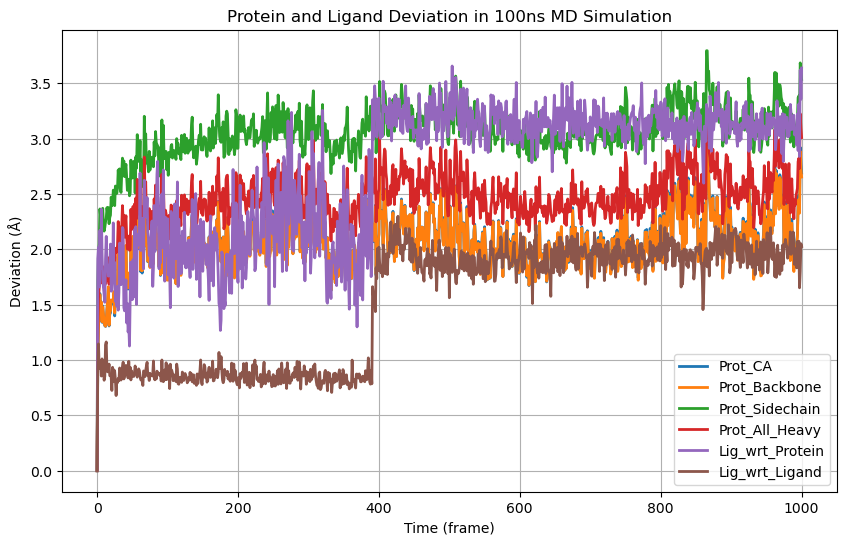

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load your raw data from the Maestro Simulation Interaction Diagram tool
# Replace the following line with your actual data loading code
raw_data = np.loadtxt('C:/Users/Shaba/Desktop/Communication/18_ChEMBL Dataset/02. Data Files/ChEMBL_Active_Docking/MDS_Figures_1_6E21/raw-data/PL_RMSD.dat')

# Extract time and deviation values for protein and ligand from the raw data
time = raw_data[:, 0]  # Assuming time is in the first column
prot_deviation = raw_data[:, [1, 2, 3, 4]]  # Columns 1-4 are for protein deviation
lig_deviation = raw_data[:, [5, 6]]  # Columns 5-6 are for ligand deviation

# Plotting
plt.figure(figsize=(10, 6))

# Plot protein deviation
plt.plot(time, prot_deviation, linewidth=2)
plt.title('Protein and Ligand Deviation in 100ns MD Simulation')
plt.xlabel('Time (frame)')
plt.ylabel('Deviation (Å)')
plt.grid(True)

# Plot ligand deviation
plt.plot(time, lig_deviation, linewidth=2)

# Set legends
prot_legend = ['Prot_CA', 'Prot_Backbone', 'Prot_Sidechain', 'Prot_All_Heavy']
lig_legend = ['Lig_wrt_Protein', 'Lig_wrt_Ligand']
all_legend = prot_legend + lig_legend
plt.legend(all_legend)

# Save the figure as a TIFF file
plt.savefig(r'C:RMSD_Figures_1_6E21.TIFF', format='TIFF', dpi=1200)


plt.show()

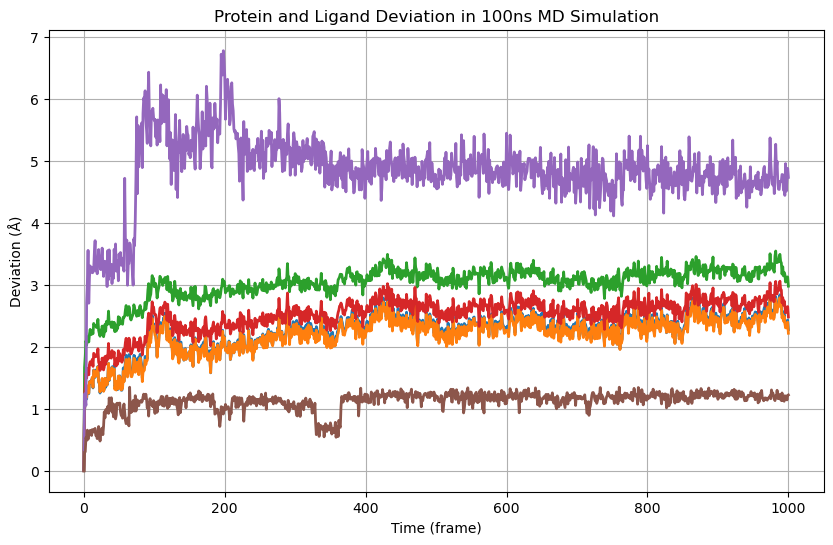

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load your raw data from the Maestro Simulation Interaction Diagram tool
# Replace the following line with your actual data loading code
raw_data = np.loadtxt('C:/Users/Shaba/Desktop/Communication/18_ChEMBL Dataset/02. Data Files/ChEMBL_Active_Docking/MDS_Figures_2_4Y23/raw-data/PL_RMSD.dat')

# Extract time and deviation values for protein and ligand from the raw data
time = raw_data[:, 0]  # Assuming time is in the first column
prot_deviation = raw_data[:, [1, 2, 3, 4]]  # Columns 1-4 are for protein deviation
lig_deviation = raw_data[:, [5, 6]]  # Columns 5-6 are for ligand deviation

# Plotting
plt.figure(figsize=(10, 6))

# Plot protein deviation
plt.plot(time, prot_deviation, linewidth=2)
plt.title('Protein and Ligand Deviation in 100ns MD Simulation')
plt.xlabel('Time (frame)')
plt.ylabel('Deviation (Å)')
plt.grid(True)

# Plot ligand deviation
plt.plot(time, lig_deviation, linewidth=2)

# Save the figure as a TIFF file
plt.savefig(r'C:RMSD_Figures_2_4Y23.TIFF', format='TIFF', dpi=1200)

plt.show()

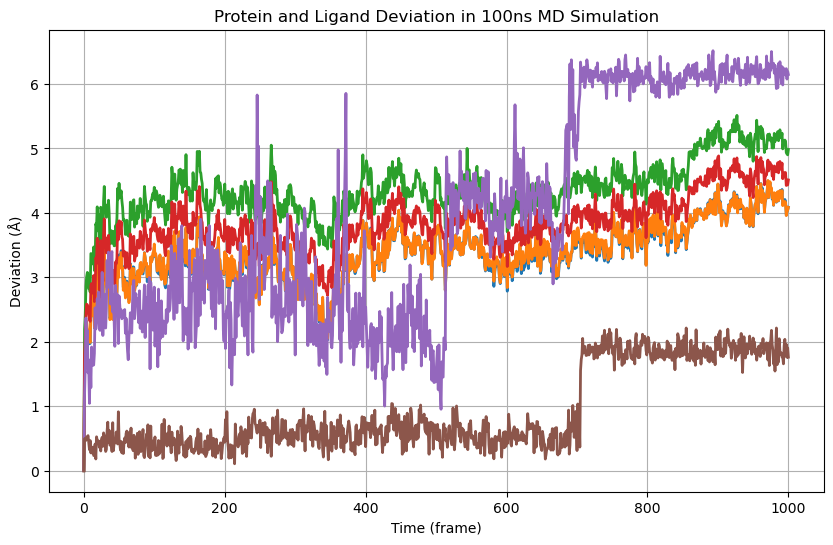

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Load your raw data from the Maestro Simulation Interaction Diagram tool
# Replace the following line with your actual data loading code
raw_data = np.loadtxt('C:/Users/Shaba/Desktop/Communication/18_ChEMBL Dataset/02. Data Files/ChEMBL_Active_Docking/MDS_Figures_3_6T8M/raw-data/PL_RMSD.dat')

# Extract time and deviation values for protein and ligand from the raw data
time = raw_data[:, 0]  # Assuming time is in the first column
prot_deviation = raw_data[:, [1, 2, 3, 4]]  # Columns 1-4 are for protein deviation
lig_deviation = raw_data[:, [5, 6]]  # Columns 5-6 are for ligand deviation

# Plotting
plt.figure(figsize=(10, 6))

# Plot protein deviation
plt.plot(time, prot_deviation, linewidth=2)
plt.title('Protein and Ligand Deviation in 100ns MD Simulation')
plt.xlabel('Time (frame)')
plt.ylabel('Deviation (Å)')
plt.grid(True)

# Plot ligand deviation
plt.plot(time, lig_deviation, linewidth=2)

# Save the figure as a TIFF file
plt.savefig(r'C:RMSD_Figures_3_6T8M.TIFF', format='TIFF', dpi=1200)


plt.show()

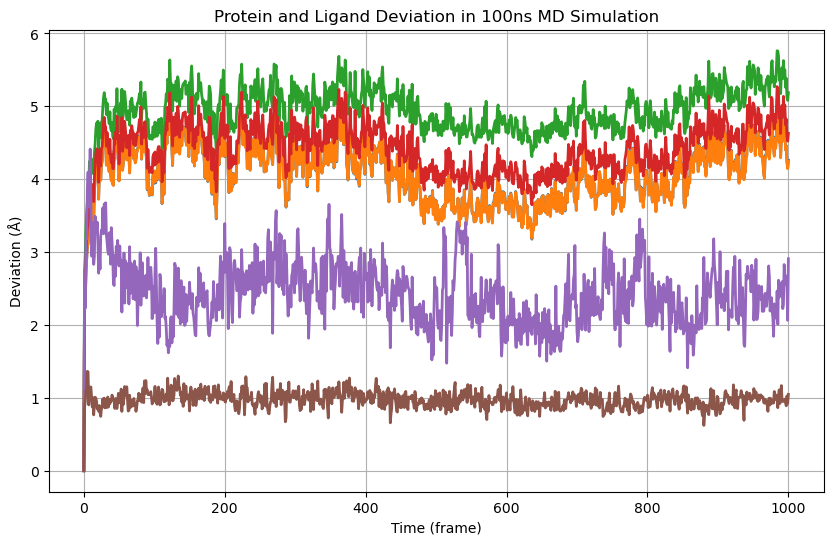

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Load your raw data from the Maestro Simulation Interaction Diagram tool
# Replace the following line with your actual data loading code
raw_data = np.loadtxt('C:/Users/Shaba/Desktop/Communication/18_ChEMBL Dataset/02. Data Files/ChEMBL_Active_Docking/MDS_Figures_4_6P8I/raw-data/PL_RMSD.dat')

# Extract time and deviation values for protein and ligand from the raw data
time = raw_data[:, 0]  # Assuming time is in the first column
prot_deviation = raw_data[:, [1, 2, 3, 4]]  # Columns 1-4 are for protein deviation
lig_deviation = raw_data[:, [5, 6]]  # Columns 5-6 are for ligand deviation

# Plotting
plt.figure(figsize=(10, 6))

# Plot protein deviation
plt.plot(time, prot_deviation, linewidth=2)
plt.title('Protein and Ligand Deviation in 100ns MD Simulation')
plt.xlabel('Time (frame)')
plt.ylabel('Deviation (Å)')
plt.grid(True)

# Plot ligand deviation
plt.plot(time, lig_deviation, linewidth=2)

# Save the figure as a TIFF file
plt.savefig(r'C:RMSD_Figures_4_6P8I.TIFF', format='TIFF', dpi=1200)


plt.show()

## RMSF Plot
Make the data like this-

Residue Chain ResName LigandContact CA Backbone Sidechain All_Heavy B-factor

0 A ACE_69 No n/a 8.897 n/a 8.897 0

remove all # sign

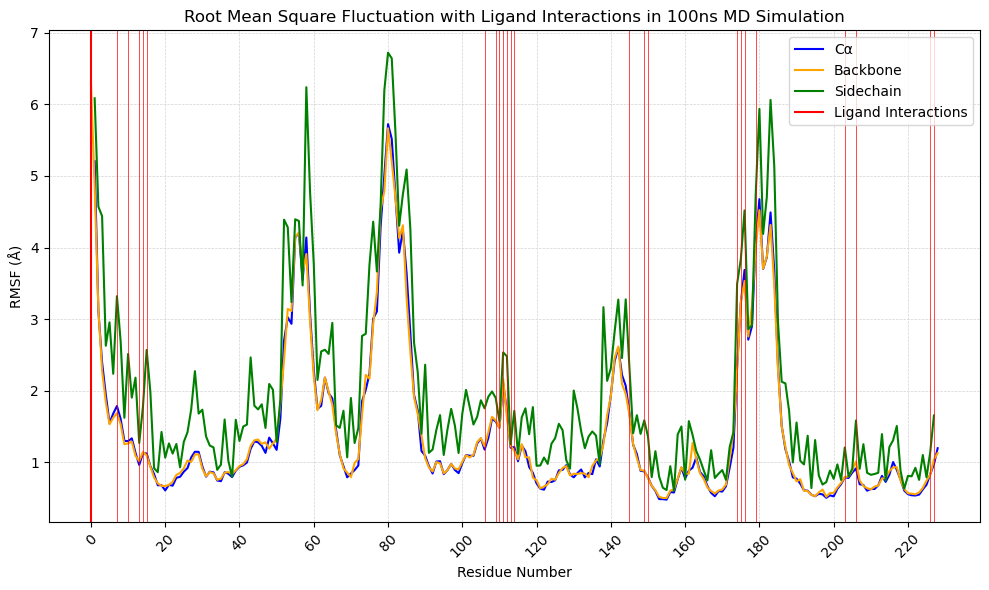

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from .dat file
file_path = "C:/Users/Shaba/Desktop/Communication/18_ChEMBL Dataset/02. Data Files/ChEMBL_Active_Docking/MDS_Figures_3_6T8M/raw-data/P_RMSF.dat"  # Update this with the path to your .dat file
df = pd.read_csv(file_path, sep="\t")

# Extract relevant columns for plotting
residues = df["Residue"]
rmsf_values_ca = df["CA"]
rmsf_values_backbone = df["Backbone"]
rmsf_values_sidechain = df["Sidechain"]
rmsf_values_all_heavy = df["All_Heavy"]
rmsf_values_b_factor = df["B-factor"]
ligand_contacts = df[df["LigandContact"] == "Yes"]["Residue"]  # Residue numbers with ligand contacts

# Plot RMSF
fig, ax = plt.subplots(figsize=(10, 6))

# Plot CA
ax.plot(residues, rmsf_values_ca, label='Cα', color='blue')

# Plot Backbone
ax.plot(residues, rmsf_values_backbone, label='Backbone', color='orange')

# Plot Sidechain
ax.plot(residues, rmsf_values_sidechain, label='Sidechain', color='green')

# Add thin bars for ligand interactions
for residue in ligand_contacts:
    ax.axvline(x=residue, color='red', linestyle='-', linewidth=0.5)
ax.axvline(color='red', label='Ligand Interactions')
# Customize plot
ax.set_title('Root Mean Square Fluctuation with Ligand Interactions in 100ns MD Simulation')
ax.set_xlabel('Residue Number')
ax.set_ylabel('RMSF (Å)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

#Legend
ax.legend(loc='upper right')  # Adjust the location of the legend to upper left

ax.set_xticks(residues[::20])
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

# Save the figure as a TIFF file
plt.savefig(r'C:RMSF_Figures_1_6E21.TIFF', format='TIFF', dpi=1200)

plt.show()


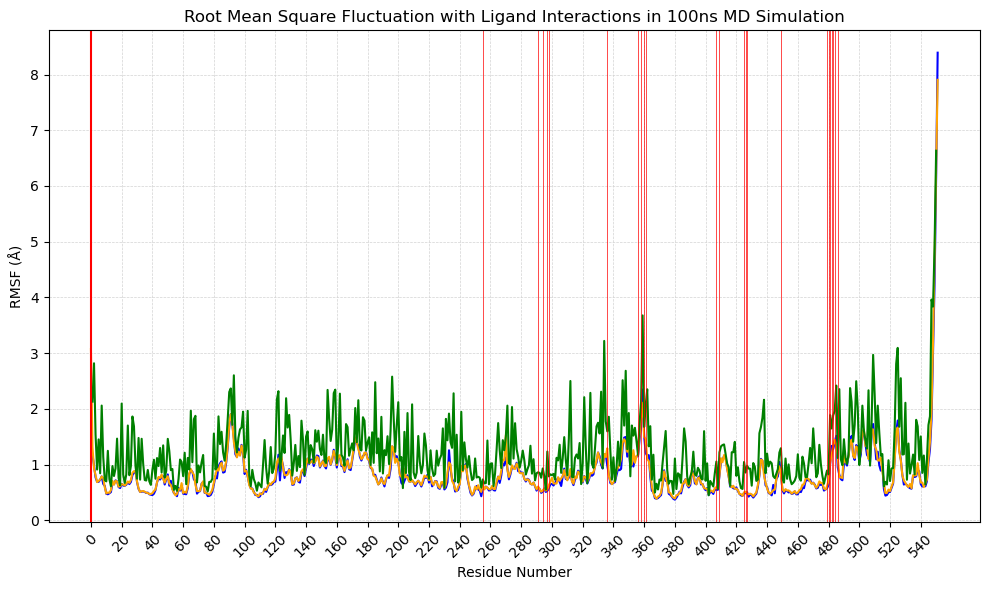

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from .dat file
file_path = "C:/Users/Shaba/Desktop/Communication/18_ChEMBL Dataset/02. Data Files/ChEMBL_Active_Docking/MDS_Figures_2_4Y23/raw-data/P_RMSF.dat"  # Update this with the path to your .dat file
df = pd.read_csv(file_path, sep="\t")

# Extract relevant columns for plotting
residues = df["Residue"]
rmsf_values_ca = df["CA"]
rmsf_values_backbone = df["Backbone"]
rmsf_values_sidechain = df["Sidechain"]
rmsf_values_all_heavy = df["All_Heavy"]
rmsf_values_b_factor = df["B-factor"]
ligand_contacts = df[df["LigandContact"] == "Yes"]["Residue"]  # Residue numbers with ligand contacts

# Plot RMSF
fig, ax = plt.subplots(figsize=(10, 6))

# Plot CA
ax.plot(residues, rmsf_values_ca, label='Cα', color='blue')

# Plot Backbone
ax.plot(residues, rmsf_values_backbone, label='Backbone', color='orange')

# Plot Sidechain
ax.plot(residues, rmsf_values_sidechain, label='Sidechain', color='green')

# Add thin bars for ligand interactions
for residue in ligand_contacts:
    ax.axvline(x=residue, color='red', linestyle='-', linewidth=0.5)
ax.axvline(color='red', label='Ligand Interactions')
# Customize plot
ax.set_title('Root Mean Square Fluctuation with Ligand Interactions in 100ns MD Simulation')
ax.set_xlabel('Residue Number')
ax.set_ylabel('RMSF (Å)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

#Legend
#ax.legend(loc='upper right')  # Adjust the location of the legend to upper left

ax.set_xticks(residues[::20])
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

# Save the figure as a TIFF file
plt.savefig(r'C:RMSF_Figures_2_4Y23.TIFF', format='TIFF', dpi=1200)

plt.show()


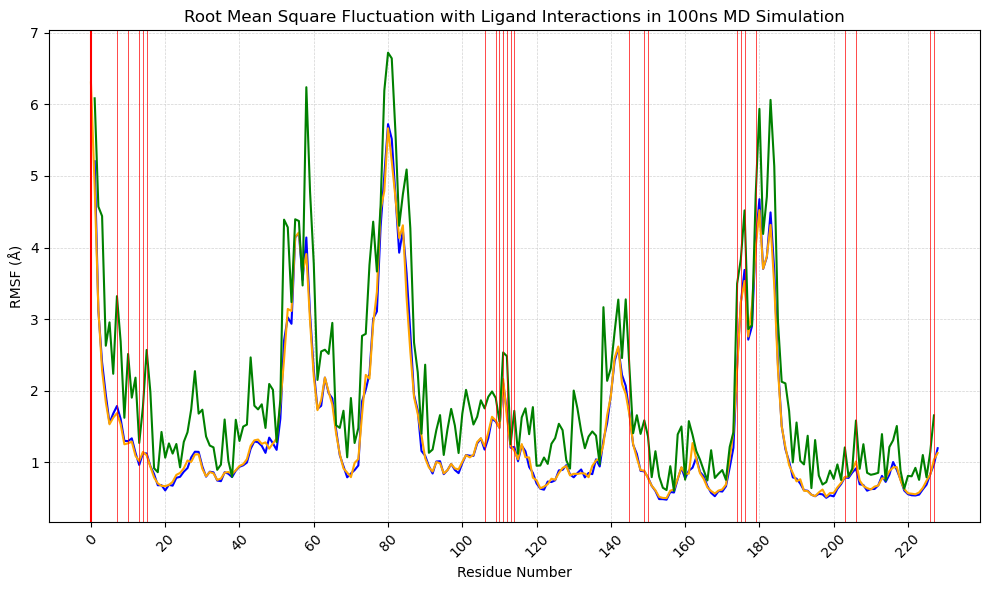

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from .dat file
file_path = "C:/Users/Shaba/Desktop/Communication/18_ChEMBL Dataset/02. Data Files/ChEMBL_Active_Docking/MDS_Figures_3_6T8M/raw-data/P_RMSF.dat"  # Update this with the path to your .dat file
df = pd.read_csv(file_path, sep="\t")

# Extract relevant columns for plotting
residues = df["Residue"]
rmsf_values_ca = df["CA"]
rmsf_values_backbone = df["Backbone"]
rmsf_values_sidechain = df["Sidechain"]
rmsf_values_all_heavy = df["All_Heavy"]
rmsf_values_b_factor = df["B-factor"]
ligand_contacts = df[df["LigandContact"] == "Yes"]["Residue"]  # Residue numbers with ligand contacts

# Plot RMSF
fig, ax = plt.subplots(figsize=(10, 6))

# Plot CA
ax.plot(residues, rmsf_values_ca, label='Cα', color='blue')

# Plot Backbone
ax.plot(residues, rmsf_values_backbone, label='Backbone', color='orange')

# Plot Sidechain
ax.plot(residues, rmsf_values_sidechain, label='Sidechain', color='green')

# Add thin bars for ligand interactions
for residue in ligand_contacts:
    ax.axvline(x=residue, color='red', linestyle='-', linewidth=0.5)
ax.axvline(color='red', label='Ligand Interactions')
# Customize plot
ax.set_title('Root Mean Square Fluctuation with Ligand Interactions in 100ns MD Simulation')
ax.set_xlabel('Residue Number')
ax.set_ylabel('RMSF (Å)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

#Legend
#ax.legend(loc='upper right')  # Adjust the location of the legend to upper left

ax.set_xticks(residues[::20])
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

# Save the figure as a TIFF file
plt.savefig(r'C:RMSF_Figures_3_6T8M.TIFF', format='TIFF', dpi=1200)

plt.show()


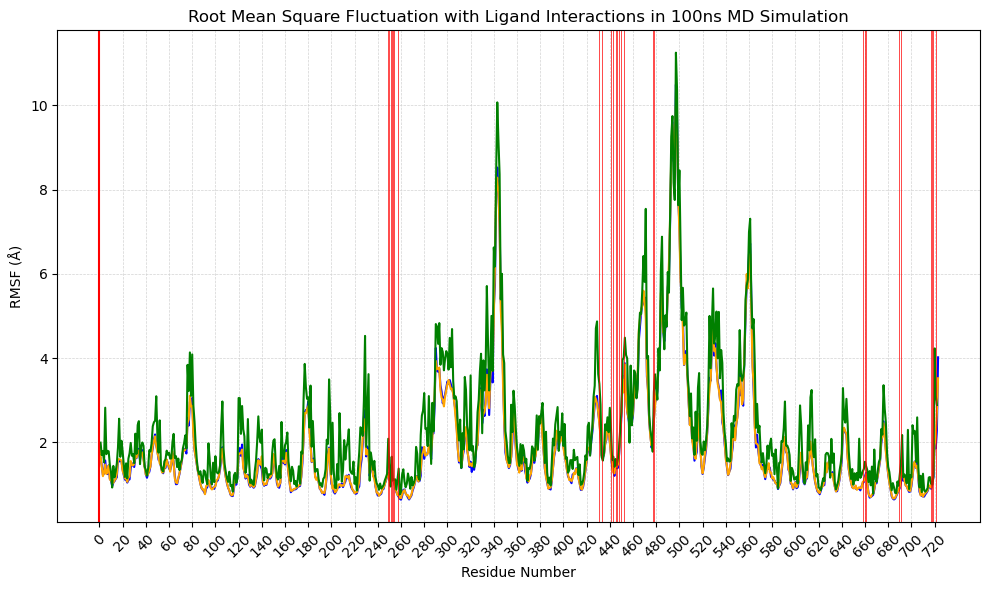

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from .dat file
file_path = "C:/Users/Shaba/Desktop/Communication/18_ChEMBL Dataset/02. Data Files/ChEMBL_Active_Docking/MDS_Figures_4_6P8I/raw-data/P_RMSF.dat"  # Update this with the path to your .dat file
df = pd.read_csv(file_path, sep="\t")

# Extract relevant columns for plotting
residues = df["Residue"]
rmsf_values_ca = df["CA"]
rmsf_values_backbone = df["Backbone"]
rmsf_values_sidechain = df["Sidechain"]
rmsf_values_all_heavy = df["All_Heavy"]
rmsf_values_b_factor = df["B-factor"]
ligand_contacts = df[df["LigandContact"] == "Yes"]["Residue"]  # Residue numbers with ligand contacts

# Plot RMSF
fig, ax = plt.subplots(figsize=(10, 6))

# Plot CA
ax.plot(residues, rmsf_values_ca, label='Cα', color='blue')

# Plot Backbone
ax.plot(residues, rmsf_values_backbone, label='Backbone', color='orange')

# Plot Sidechain
ax.plot(residues, rmsf_values_sidechain, label='Sidechain', color='green')

# Add thin bars for ligand interactions
for residue in ligand_contacts:
    ax.axvline(x=residue, color='red', linestyle='-', linewidth=0.5)
ax.axvline(color='red', label='Ligand Interactions')
# Customize plot
ax.set_title('Root Mean Square Fluctuation with Ligand Interactions in 100ns MD Simulation')
ax.set_xlabel('Residue Number')
ax.set_ylabel('RMSF (Å)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

#Legend
#ax.legend(loc='upper right')  # Adjust the location of the legend to upper left

ax.set_xticks(residues[::20])
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

# Save the figure as a TIFF file
plt.savefig(r'C:RMSF_Figures_4_6P8I.TIFF', format='TIFF', dpi=1200)

plt.show()
